# Submit Predictions

This notebook shows how to prepare a submission of your model's predictions on the test data for the computation.

In [1]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from pathlib import Path
from natsort import natsorted
import numpy as np
from safetensors.torch import load_model
import torch 
import pandas as pd

from utils import hvatnet
from utils.creating_dataset import LEFT_TO_RIGHT_HAND


## Load pre-trained model

This code loads the pre-trained baseline model - might be different for your model.

In [7]:
device = 'cpu'
dtype = torch.float32

weights =  r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_05_11_run_fedya\step_4050_loss_0.2747.safetensors"

MODEL_TYPE = 'hvatnet'
model_config = hvatnet.Config(n_electrodes=8, n_channels_out=20,
                            n_res_blocks=5, n_blocks_per_layer=2,
                            n_filters=128, kernel_size=3,
                            strides=(2, 2, 2), dilation=3, 
                            small_strides = (1, 1))
model = hvatnet.HVATNetv3(model_config)

load_model(model, weights)

model = model.to(device).to(dtype)

Number of parameters: 3224676


In [ ]:
device = 'cpu'
dtype = torch.float32

weights =  r"C:\Users\nodos\PycharmProjects\amputants\tutorials\logs\test_05_11_run_fedya\step_2850_loss_0.2795.safetensors"

MODEL_TYPE = 'hvatnet'
model_config = hvatnet.Config(n_electrodes=8, n_channels_out=20,
                            n_res_blocks=3, n_blocks_per_layer=3,
                            n_filters=128, kernel_size=3,
                            strides=(2, 2, 2), dilation=2, 
                            small_strides = (2, 2))
model = hvatnet.HVATNetv3(model_config)

load_model(model, weights)

model = model.to(device).to(dtype)

Number of parameters: 4210788


### Save `submission.cvs` file

This code shows how the data was prepare and downsampled during inference. Make sure that your data is processed similarly!

In [8]:
DATA_PATH = Path(r"C:\Users\nodos\Desktop\ДИПЛОМ\Аня диплом\dataset_v2_blocks\dataset_v2_blocks")
test_data_name = 'fedya_tropin_standart_elbow_left'  # shoould match `test_dataset_list` used to train the model


data_folder = DATA_PATH / "amputant" / "left" / test_data_name / "preproc_angles" / "submit"
all_paths = natsorted(data_folder.glob('*.npz'))
print(f'Found {len(all_paths)} samples in {data_folder}')


Found 72 samples in C:\Users\nodos\Desktop\ДИПЛОМ\Аня диплом\dataset_v2_blocks\dataset_v2_blocks\amputant\left\fedya_tropin_standart_elbow_left\preproc_angles\submit


In [9]:

pred_list = []

# loop over each trial
for i, p in enumerate(all_paths):
    # get EMG data 
    sample = np.load(p)
    myo = sample['data_myo']
    myo = myo[:, LEFT_TO_RIGHT_HAND]

    # predictions will have to be downsampled
    gt_len = myo[::8].shape[0]

    # padding
    target_length = (myo.shape[0] + 255) // 256 * 256
    padded_myo = np.pad(myo, ((0, target_length - myo.shape[0]), (0, 0)), mode='constant', constant_values=0)

    # some prediction. might be slididng window.
    preds = model.inference(padded_myo)
    preds_downsampled = preds[:gt_len]
    print(f"Completed {i+1}/{len(all_paths)}. Loaded data: {myo.shape} - padded to: {padded_myo.shape} - predictions {preds.shape} - downsampled to: {preds_downsampled.shape}")
    pred_list.append(preds_downsampled)

pred_cat = np.concatenate(pred_list, axis=0)
df = pd.DataFrame(pred_cat)
df.head()

Completed 1/72. Loaded data: (3721, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (466, 20)
Completed 2/72. Loaded data: (3725, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (466, 20)
Completed 3/72. Loaded data: (3724, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (466, 20)
Completed 4/72. Loaded data: (3724, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (466, 20)
Completed 5/72. Loaded data: (3729, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (467, 20)
Completed 6/72. Loaded data: (3726, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (466, 20)
Completed 7/72. Loaded data: (3724, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (466, 20)
Completed 8/72. Loaded data: (3728, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (466, 20)
Completed 9/72. Loaded data: (3724, 8) - padded to: (3840, 8) - predictions (480, 20) - 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.231928,-0.022436,0.402423,0.094868,0.185136,-0.002209,0.410683,0.066798,0.287478,0.010185,0.513789,0.266438,0.322758,0.033135,0.352393,0.147607,0.192227,-0.099880,0.368584,-0.140891
1,0.225159,-0.036239,0.409873,0.116660,0.159820,-0.006980,0.443965,0.084534,0.269090,0.012501,0.504997,0.278756,0.325774,0.038633,0.382400,0.142040,0.221210,-0.143651,0.350335,-0.186840
2,0.216243,-0.040475,0.439907,0.105691,0.201591,-0.015153,0.419505,0.060707,0.312658,0.010190,0.461729,0.270425,0.310332,0.031502,0.402367,0.123275,0.258520,-0.140580,0.351522,-0.196887
3,0.239311,-0.038427,0.400374,0.098108,0.238387,-0.015190,0.398897,0.052878,0.357158,0.017875,0.429283,0.237202,0.354328,0.031589,0.339900,0.093321,0.261657,-0.141778,0.336352,-0.179729
4,0.218434,-0.047509,0.408794,0.106814,0.266940,-0.010177,0.382000,0.056777,0.364784,0.019934,0.408916,0.230388,0.378745,0.028404,0.329847,0.110300,0.238594,-0.157262,0.325411,-0.151341


In addition to the predictions, your data should also include a sample id column.

In [10]:
df.insert(0, "sample_id", range(1, 1 + len(df)))

Finally, save to a CSV file. This is what you'll upload to Kaggle for the competition.

In [11]:
df.to_csv('5_11_type_027_loss_4000_step.csv', index=False)

In [41]:
df.shape

(26829, 21)

Сверка версий с лоссом 29 и лоссом 27

In [50]:
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

loss275 = pd.read_csv('loss_0_275.csv')
loss29 = pd.read_csv('submit_file.csv')

# Удалите столбец sample_id для расчета косинусного сходства
features275 = loss275.drop(columns=['sample_id'])
features29 = loss29.drop(columns=['sample_id'])

# Рассчитайте косинусное сходство для каждой строки
cosine_similarities = []
for i in tqdm(range(len(features275))):
    vector275 = features275.iloc[i].values.reshape(1, -1)
    vector29 = features29.iloc[i].values.reshape(1, -1)
    similarity = cosine_similarity(vector275, vector29)[0][0]
    cosine_similarities.append(similarity)

# Создайте новый датафрейм с sample_id и косинусным сходством
result_df = pd.DataFrame({
    'sample_id': loss275['sample_id'],
    'cosine_similarity': cosine_similarities
})

# Отсортируйте датафрейм по убыванию косинусного сходства
sim_275_29 = result_df.sort_values(by='cosine_similarity', ascending=False)


100%|██████████| 26829/26829 [00:20<00:00, 1322.36it/s]


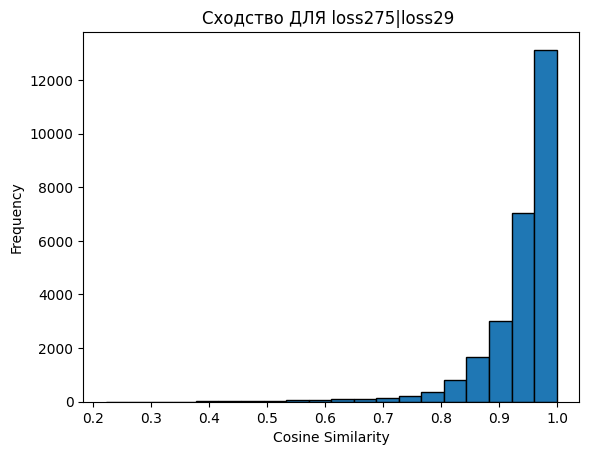

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sim_275_29['cosine_similarity'], bins=20, edgecolor='black')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Cходство ДЛЯ loss275|loss29 ')
plt.show()

In [51]:
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

loss27 = pd.read_csv('loss_0_27.csv')
loss29 = pd.read_csv('submit_file.csv')

# Удалите столбец sample_id для расчета косинусного сходства
features27 = loss27.drop(columns=['sample_id'])
features29 = loss29.drop(columns=['sample_id'])

# Рассчитайте косинусное сходство для каждой строки
cosine_similarities = []
for i in tqdm(range(len(features275))):
    vector275 = features27.iloc[i].values.reshape(1, -1)
    vector29 = features29.iloc[i].values.reshape(1, -1)
    similarity = cosine_similarity(vector275, vector29)[0][0]
    cosine_similarities.append(similarity)

# Создайте новый датафрейм с sample_id и косинусным сходством
result_df = pd.DataFrame({
    'sample_id': loss27['sample_id'],
    'cosine_similarity': cosine_similarities
})

# Отсортируйте датафрейм по убыванию косинусного сходства
sim_27_29 = result_df.sort_values(by='cosine_similarity', ascending=False)


100%|██████████| 26829/26829 [00:21<00:00, 1269.68it/s]


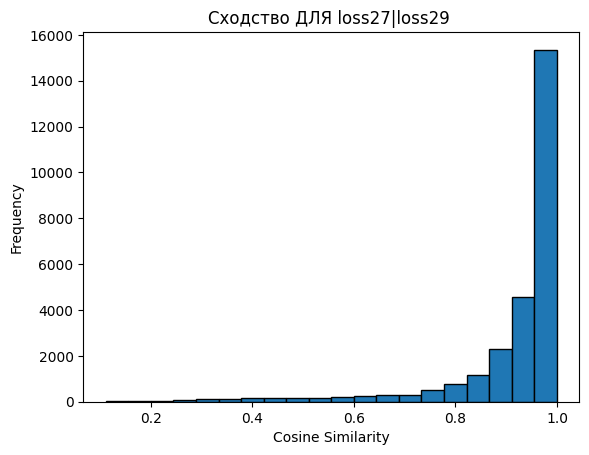

In [52]:
import matplotlib.pyplot as plt
plt.hist(sim_27_29['cosine_similarity'], bins=20, edgecolor='black')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Cходство ДЛЯ loss27|loss29 ')
plt.show()

In [53]:
sim_27_29

,sample_id,cosine_similarity
4432,4433,0.999303
11781,11782,0.999134
16162,16163,0.999105
26308,26309,0.999088
26107,26108,0.999060
...,...,...
25139,25140,0.136979
25140,25141,0.129526
23102,23103,0.125345
21792,21793,0.124543


In [54]:
sim_275_29

,sample_id,cosine_similarity
21085,21086,0.999424
24823,24824,0.999375
3988,3989,0.999326
21084,21085,0.999231
9557,9558,0.999229
...,...,...
21791,21792,0.253726
3863,3864,0.252957
21793,21794,0.229209
21789,21790,0.227016


In [61]:
set1 = {1, 2, 3, 4, 5}
set2 = {4, 5, 6, 7, 8}
iou(set1, set2)

0.25

In [60]:
import pandas as pd
from sklearn.metrics import jaccard_score

# Определите пороги косинусного сходства
thresholds = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.25]

# Создайте списки sample_id для каждого порога
sim_27_29_sets = {threshold: set(sim_27_29[sim_27_29['cosine_similarity'] <= threshold]['sample_id'].tolist()) for threshold in thresholds}
sim_275_29_sets = {threshold: set(sim_275_29[sim_275_29['cosine_similarity'] <= threshold]['sample_id'].tolist()) for threshold in thresholds}

def iou(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Рассчитайте сходство между списками sample_id для каждого порога
similarities = []
for threshold in tqdm(thresholds):
    set1 = sim_27_29_sets[threshold]
    set2 = sim_275_29_sets[threshold]
    similarity = iou(set1, set2)
    similarities.append(similarity)

# Создайте таблицу с результатами
result_df = pd.DataFrame({
    'threshold': thresholds,
    'similarity': similarities
})


result_df


100%|██████████| 9/9 [00:00<00:00, 899.92it/s]


,threshold,similarity
0,1.00,1.000000
1,0.90,0.331598
2,0.80,0.213380
3,0.70,0.170886
4,0.60,0.124256
5,0.50,0.085747
6,0.40,0.049251
7,0.30,0.071429
8,0.25,0.034091
